# Import packages

In [ ]:
import sys
sys.path.append("..")
from liver_microsome_prediction.utils import *

In [9]:
from analysis_tools import eda

# Load data

In [137]:
stats

<module 'scipy.stats' from '/root/.cache/pypoetry/virtualenvs/liver-microsome-prediction-DlPApp_5-py3.10/lib/python3.10/site-packages/scipy/stats/__init__.py'>

In [44]:
train_data = pd.read_csv(PATH.train)
targets = ['MLM', 'HLM']
train_data

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.01,50.68,3.26,400.50,5,2,8,3.26,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.27,50.59,2.17,301.41,2,1,2,2.17,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.59,80.89,1.59,297.36,5,0,3,1.58,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC5)CC4)c3C)nn2)cc1,5.71,2.00,4.77,494.65,6,0,5,3.48,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.27,99.99,2.33,268.31,3,0,1,2.34,42.43
...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.56,3.08,3.41,396.19,3,1,5,3.41,64.74
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccccc12,35.56,47.63,1.91,359.38,4,1,3,1.84,77.37
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.15,1.79,1.94,261.32,3,1,6,2.12,70.14
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.03,2.77,0.99,284.70,5,1,5,0.99,91.51


In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3498 entries, 0 to 3497
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3498 non-null   object 
 1   SMILES                      3498 non-null   object 
 2   MLM                         3498 non-null   float64
 3   HLM                         3498 non-null   float64
 4   AlogP                       3496 non-null   float64
 5   Molecular_Weight            3498 non-null   float64
 6   Num_H_Acceptors             3498 non-null   int64  
 7   Num_H_Donors                3498 non-null   int64  
 8   Num_RotatableBonds          3498 non-null   int64  
 9   LogD                        3498 non-null   float64
 10  Molecular_PolarSurfaceArea  3498 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 300.7+ KB


# Missing values

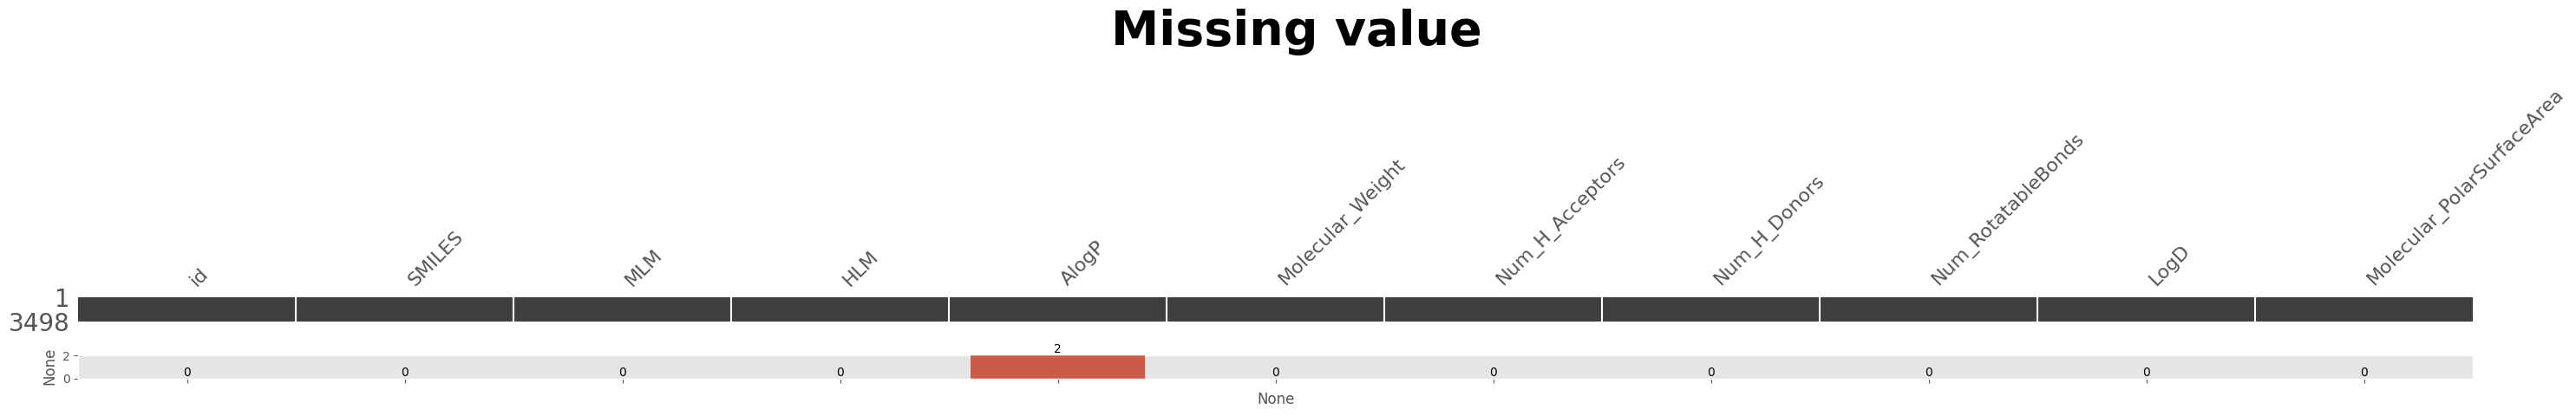

In [15]:
eda.plot_missing_value(train_data, figsize=(30, 5))

In [21]:
train_data[train_data.AlogP.isna()]

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
2796,TRAIN_2796,[H][C@]1(CC[C@@]2([H])[C@@H](C)C=CC3=C[C@H](C)C[C@H](OC(=O)C(C)(C)CC)[C@@]32[H])C[C@@H](O)CC(=O)O1,0.55,0.20,NaN,418.57,5,1,7,4.63,72.83
3387,TRAIN_3387,COc1cc2c(cc1OC)/C(=N\c1ccccc1)N(Cc1ccccc1F)CC2,0.24,3.20,NaN,390.45,3,0,5,4.91,34.06


In [161]:
train_data.loc[train_data.AlogP.isna(), 'AlogP'] = train_data.AlogP.mean()

# EDA

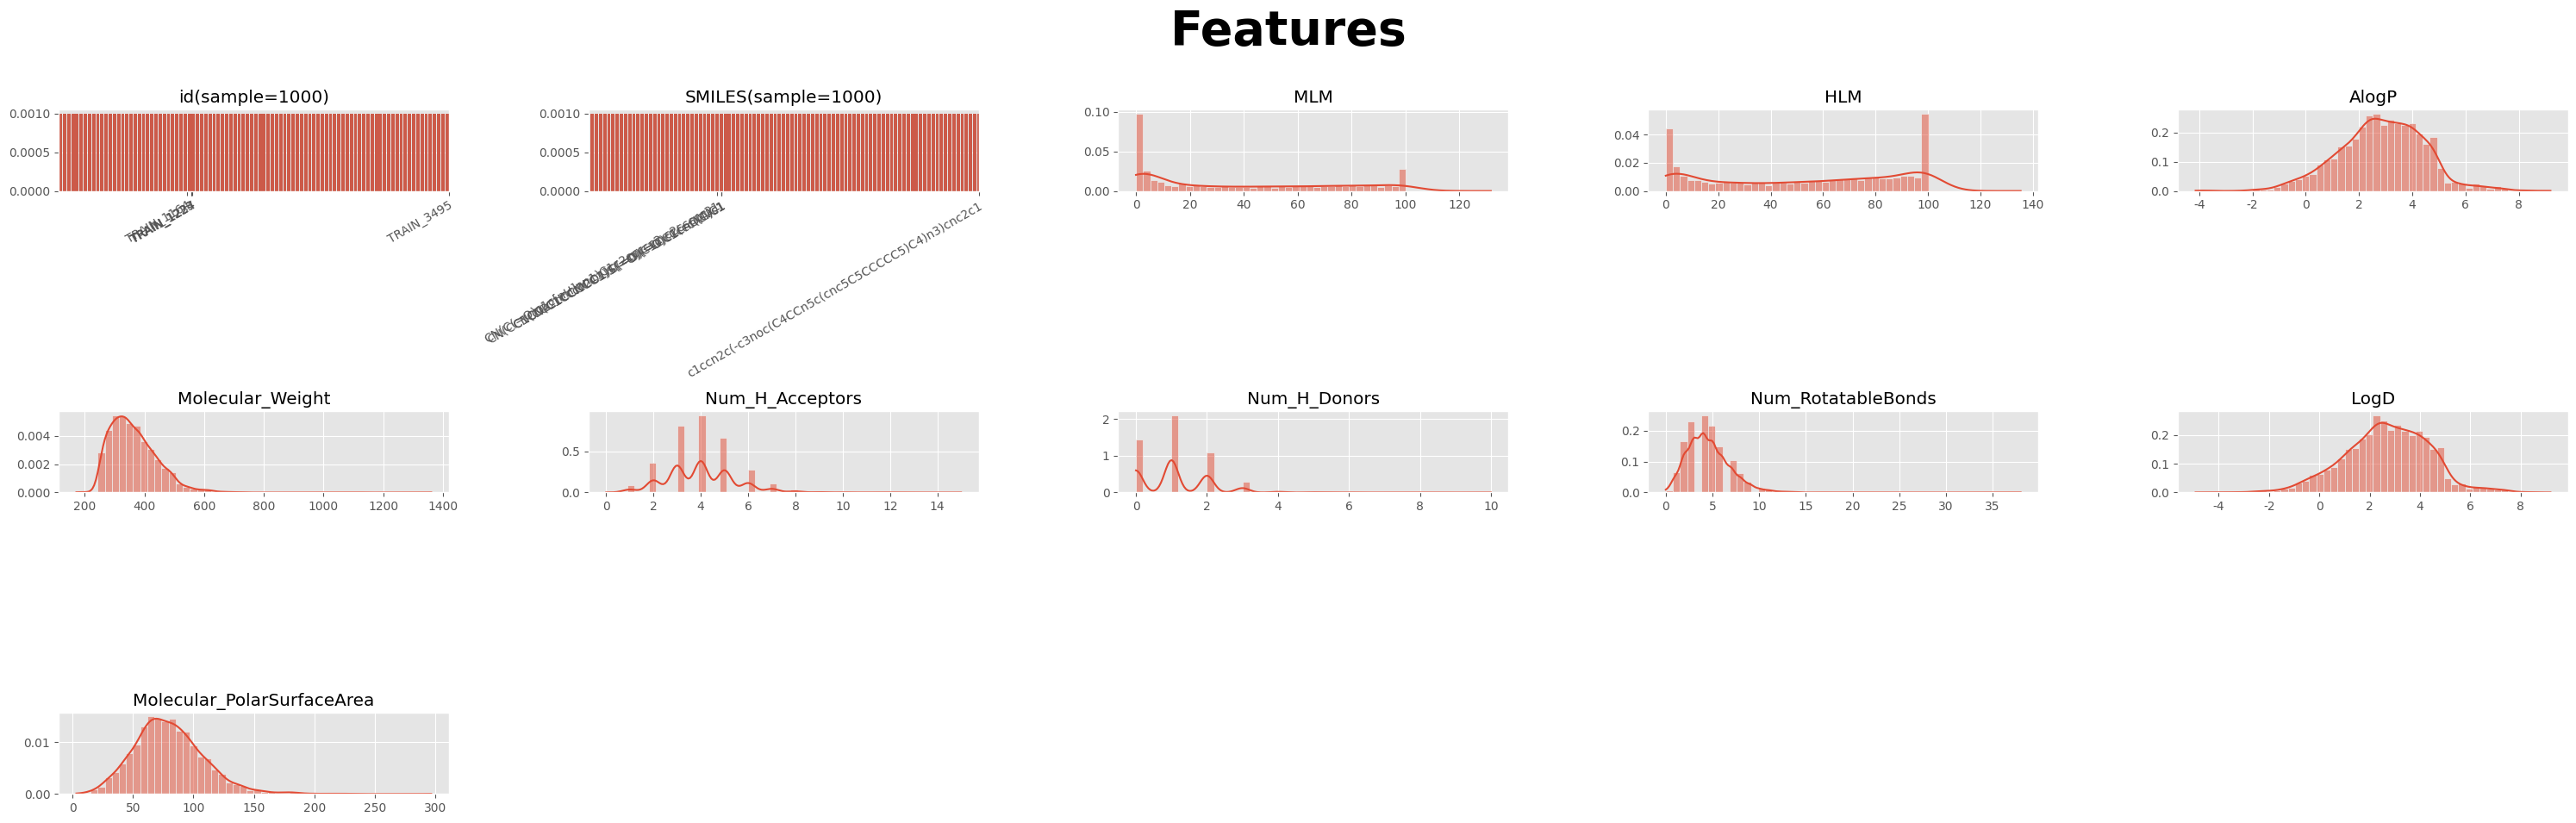

In [23]:
eda.plot_features(train_data)

- 대부분의 feature들이 모두 종모양의 분포를 보여주고 있기 때문에 standardization만으로도 충분

# targets
- HLM과 MLM은 `대사되지 않고 남아있는 화합물의 양을(%) LC-MS/MS로 측정`된 %값으로, `[0, 100]` 범위로 clipping
- Unbalance를 고려한 box-cox 변환을 취한 변수를 추가

In [140]:
def process_target(df, target, prefix='boxcox_'):
    min_pos    = df[df[target] > 0][target].min()
    df[target] = df[target].clip(min_pos, 100)
    df[prefix+target], lmbda = stats.boxcox(df[target])
    return df

def process_targets(df, targets, prefix='boxcox_'):
    for target in targets:
        df = process_target(df, target, prefix)
    return df

In [141]:
train_data = process_targets(train_data, targets)
train_data

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,boxcox_MLM,boxcox_HLM
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.01,50.68,3.26,400.50,5,2,8,3.26,117.37,5.34,14.08
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.27,50.59,2.17,301.41,2,1,2,2.17,73.47,5.64,14.06
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.59,80.89,1.59,297.36,5,0,3,1.58,62.45,2.21,18.78
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC5)CC4)c3C)nn2)cc1,5.71,2.00,4.77,494.65,6,0,5,3.48,92.60,2.25,0.85
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.27,99.99,2.33,268.31,3,0,1,2.34,42.43,9.20,21.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3493,TRAIN_3493,Cn1nc(CNC(=O)Cn2nc(C(F)(F)F)c3c2CCC3)c(Cl)c1Cl,1.56,3.08,3.41,396.19,3,1,5,3.41,64.74,0.47,1.56
3494,TRAIN_3494,CCn1[nH]cc/c1=N\C(=O)c1nn(-c2ccccc2)c(=O)c2ccccc12,35.56,47.63,1.91,359.38,4,1,3,1.84,77.37,6.16,13.54
3495,TRAIN_3495,CCOC(=O)CCCc1nc2cc(N)ccc2n1C,56.15,1.79,1.94,261.32,3,1,6,2.12,70.14,7.50,0.69
3496,TRAIN_3496,Nc1cc(C(=O)OCCC2CCOC2=O)cnc1Cl,0.03,2.77,0.99,284.70,5,1,5,0.99,91.51,-2.23,1.37


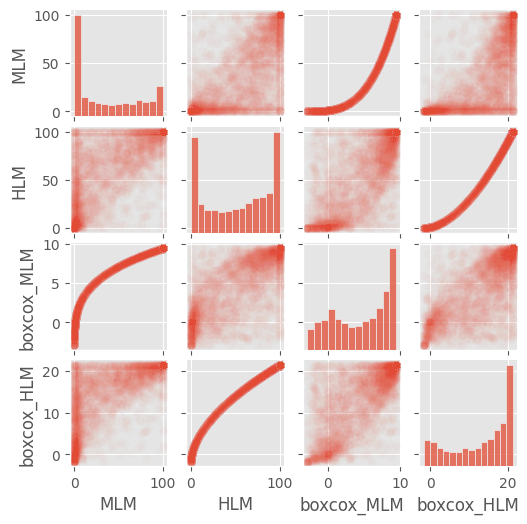

In [134]:
eda.plot_pair(targets_data, figsize=(5, 5), alpha=0.02)

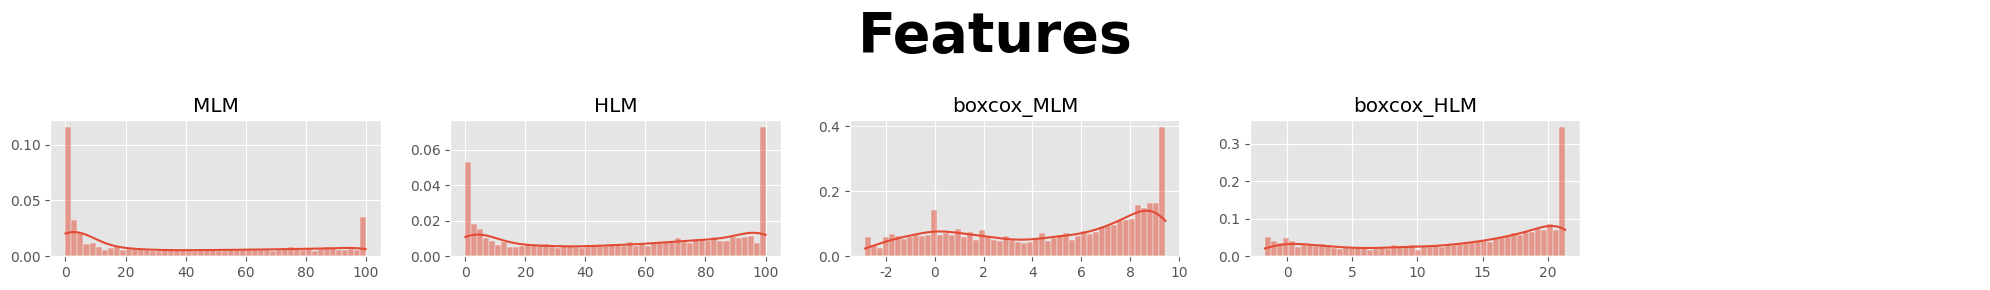

In [136]:
targets_data = train_data[targets + ['boxcox_' + target for target in targets]]
eda.plot_features(targets_data, figsize=(20, 3))